In [411]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
# plt.style.use('fivethirtyeight')
import os

from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score, precision_score, accuracy_score, classification_report, roc_auc_score

from tqdm.notebook import tqdm

In [199]:
df = pd.read_csv('clean_vizathon.csv', index_col=0)

/Users/jared/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (10,15) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [200]:
display(df.head(3))
print(df.shape)

,index,game_id,season,day_num,date,team_id,team_name,team_city,team_state,team_dist_from_home,...,opp_blks,opp_pfs,opp_poss,opp_elo_before_game,opp_elo_after_game,opp_elo_win_prob,team_off_eff,team_def_eff,opp_off_eff,opp_def_eff
0,184715,2003_2002-11-14_1104_1328,2003,10,2002-11-14,1328,Oklahoma,Norman,OK,,...,1,22,47,700.0,712.0,0.5,100.000000,109.677419,109.677419,100.000000
1,184714,2003_2002-11-14_1104_1328,2003,10,2002-11-14,1104,Alabama,Tuscaloosa,AL,,...,2,20,48,700.0,688.0,0.5,109.677419,100.000000,100.000000,109.677419
2,161722,2003_2002-11-14_1272_1393,2003,10,2002-11-14,1272,Memphis,Memphis,TN,,...,6,16,64,700.0,688.0,0.5,83.333333,75.000000,75.000000,83.333333


(184940, 58)


In [202]:
df = df.applymap(lambda x:  x.strip() if isinstance(x, str) else x)

#### Note:
Each game is basically duplicated with the two opposing teams each considered once 'team' and once 'opponent'. 
These should be removed.

In [204]:
df.drop_duplicates(subset='game_id',inplace=True)

In [206]:
df.shape

(92470, 58)

### Create a logistic regression model.
To make statistcal inferences about the model's coefficients, must verify assumptions:
1. Dependent variable(win/lose) is binary. 
2. Observations must be independent of each other (no matched data, e.g. delete duplicate game IDs)
3. Multicollinearity must be small or none  among the independent variables
4. Independent variables are linearly related to the log odds (not to dependent variable)
5. Large enough sample size for number of independent variables considered

In [207]:
# Engineer simple column, 'difference between elo'
df['team_diff_elo'] = df.team_elo_before_game - df.opp_elo_before_game

In [209]:
df[['team_elo_before_game', 'opp_elo_before_game', 'team_diff_elo']]

,team_elo_before_game,opp_elo_before_game,team_diff_elo
0,700.000000,700.000000,0.000000
2,700.000000,700.000000,0.000000
4,700.000000,700.000000,0.000000
5,700.000000,700.000000,0.000000
7,700.000000,700.000000,0.000000
...,...,...,...
184927,559.859998,644.014168,-84.154171
184928,790.247175,798.340247,-8.093072
184930,865.022657,787.644108,77.378549
184932,697.674950,833.343926,-135.668975


In [210]:
offEff = df.team_off_eff
tnames = df.team_name.unique()
seasons = np.arange(2003, 2021)

In [ ]:
def avg_to_date(df, column: str, out: str):
    "Sets column 'out' in DataFrame 'df' to the average of column "
    for season in tqdm(seasons):
        for tname in tnames:
            df.loc[(df.team_name == tname) & (df.season == season), 'avgTeamOffEff'] = df.team_off_eff[(df.team_name == tname) & (df.season == season)].rolling(1).mean()
    os.system('say "all done"')

In [211]:
for season in tqdm(seasons):
    for tname in tnames:
        df.loc[(df.team_name == tname) & (df.season == season), 'avgTeamOffEff'] = df.team_off_eff[(df.team_name == tname) & (df.season == season)].rolling(1).mean()
os.system('say "all done"')

0

In [422]:
pd.rolling.mean(df.set_index('date').groupby(['team_id', 'season'])['team_def_eff'],window=365, freq='D',min_periods=1)

AttributeError: module 'pandas' has no attribute 'rolling'

In [425]:
pd.api.indexers.BaseIndexer()

AttributeError: module 'pandas.api' has no attribute 'indexers'

In [212]:
df.shape

(92470, 60)

In [297]:
columns = ['avgTeamOffEff', 'team_diff_elo']
X = df[columns]
y = df.team_win
X

,avgTeamOffEff,team_diff_elo
0,100.000000,0.000000
2,83.333333,0.000000
4,92.207792,0.000000
5,108.000000,0.000000
7,74.390244,0.000000
...,...,...
184927,75.000000,-84.154171
184928,104.545455,-8.093072
184930,93.506494,77.378549
184932,58.181818,-135.668975


In [265]:
X.describe()

,avgTeamOffEff,team_diff_elo
count,92470.000000,92470.000000
mean,89.497447,0.275192
std,16.069054,107.186640
min,35.135135,-504.387766
25%,78.651685,-65.860954
50%,88.157895,0.000000
75%,98.666667,66.585960
max,280.952381,509.305507


In [217]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1ac0c93c8>,
      dtype=object)

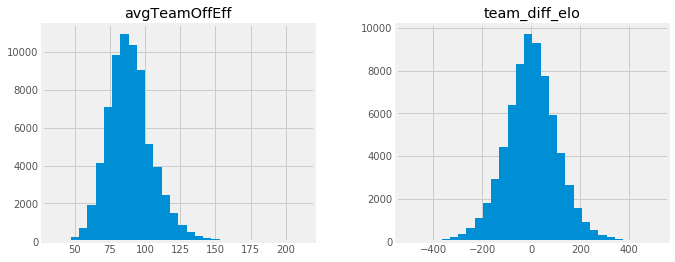

In [389]:
X_train.hist(bins=30, figsize=(10, 4))

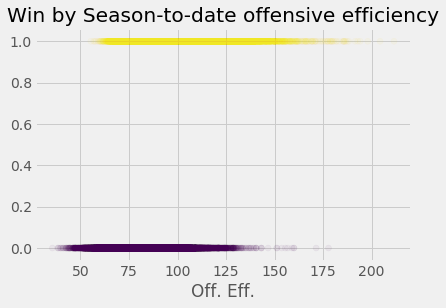

In [304]:
fig, ax = plt.subplots()
ax.set_title('Win by Season-to-date offensive efficiency')
ax.set_xlabel('Off. Eff.')
ax.scatter(X_train.iloc[:,0], y_train, c=y_train+1, alpha=0.05)


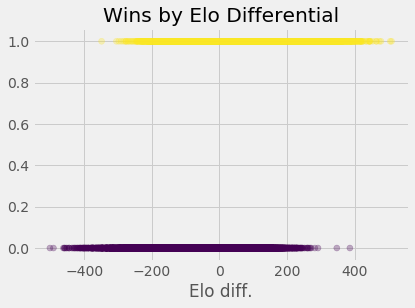

In [305]:
fig, ax = plt.subplots()
ax.set_title('Wins by Elo Differential')
ax.set_xlabel('Elo diff.')
ax.scatter(X_train.iloc[:,1], y_train, c=y_train, alpha=0.3)

In [218]:
LR = LogisticRegression()
LR.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [260]:
y_train_preds = LR.predict(X_train)

Text(0, 0.5, "Difference from Opponent's Elo")

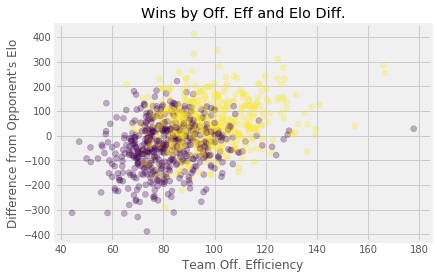

In [323]:
fig, ax = plt.subplots()

ax.scatter(X_train.iloc[:1000,0], X_train.iloc[:1000,1], c=y_train[:1000], alpha=.3)
ax.set_title('Wins by Off. Eff and Elo Diff.')
ax.set_xlabel('Team Off. Efficiency')
ax.set_ylabel("Difference from Opponent's Elo")

In [345]:
grid1 = np.linspace(0, 350, 50)
grid2 = np.linspace(-550, 550, 50)
grid_X = np.array([[x1, x2] for x1 in grid1 for x2 in grid2])

grid_y = LR.predict(grid_X)

win_X, lose_X = grid_X[grid_y == 1], grid_X[grid_y == 0]


In [355]:
win_X.T.shape

(2, 1850)

Shaded orange area is predicted win area, shaded blue is predicted loss


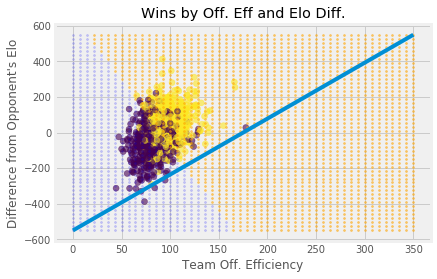

In [384]:
fig, ax = plt.subplots()

ax.scatter(X_train.iloc[:1000,0], X_train.iloc[:1000,1], c=y_train[:1000], alpha=.6)
ax.set_title('Wins by Off. Eff and Elo Diff.')
ax.set_xlabel('Team Off. Efficiency')
ax.set_ylabel("Difference from Opponent's Elo")
ax.scatter(win_X[:, 0], win_X[:, 1], c='orange' ,alpha=0.6, s=4 )
ax.scatter(lose_X[:, 0], lose_X[:, 1], c='blue' ,alpha=0.2, s=4 )
ax.plot(grid1, grid2)
print("Shaded orange area is predicted win area, shaded blue is predicted loss")

In [383]:
LR.coef_

array([[0.07785616, 0.01048655]])

In [ ]:
gy2 = LR.coef_[0] * grid1 

In [219]:
y_pred = LR.predict(X_test)

In [220]:
LR_prec = precision_score(y_test, y_pred)
LR_rec = recall_score(y_test, y_pred)
LR_acc = accuracy_score(y_test, y_pred)

In [390]:
print(LR_acc, LR_rec, LR_prec)

0.7675837010121983 0.7598367063319725 0.7703416696019725


In [393]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.76      0.78      0.77     11605
           1       0.77      0.76      0.77     11513

    accuracy                           0.77     23118
   macro avg       0.77      0.77      0.77     23118
weighted avg       0.77      0.77      0.77     23118



### Trying Multiple Models

In [395]:
def calculate_threshold_values(prob, y):
    '''
    Build dataframe of the various confusion-matrix ratios by threshold
    from a list of predicted probabilities and actual y values
    '''
    df = pd.DataFrame({'prob': prob, 'y': y})
    df.sort_values('prob', inplace=True)
    
    actual_p = df.y.sum()
    actual_n = df.shape[0] - df.y.sum()

    df['tn'] = (df.y == 0).cumsum()
    df['fn'] = df.y.cumsum()
    df['fp'] = actual_n - df.tn
    df['tp'] = actual_p - df.fn

    df['fpr'] = df.fp/(df.fp + df.tn)
    df['tpr'] = df.tp/(df.tp + df.fn)
    df['precision'] = df.tp/(df.tp + df.fp)
    df = df.reset_index(drop=True)
    return df
 

In [396]:
def plot_roc(ax, df, name):
    ax.plot([1]+list(df.fpr), [1]+list(df.tpr), label=name)
#     ax.plot([0,1],[0,1], 'k', label="random")
    ax.set_xlabel('False Positive Rate', fontsize=16)
    ax.set_ylabel('True Positive Rate', fontsize=16)
    ax.set_title('ROC Curve - Model Comparison', fontweight='bold', fontsize=24)
    ax.legend(fontsize=14)

In [417]:
def modelling(X_train, X_test, y_train, y_test, model):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    
    probs = model.predict_proba(X_test)[:,1]
    roc_auc = roc_auc_score(y_test, probs)
    thresh_df = calculate_threshold_values(probs, y_test)

    return (precision, recall, accuracy, thresh_df, roc_auc, model)

In [418]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

logistic = LogisticRegression()
gb = GradientBoostingClassifier()
rf = RandomForestClassifier()
dt = DecisionTreeClassifier()
kn = KNeighborsClassifier()

In [419]:
model_list = [logistic, gb, rf, dt, kn]

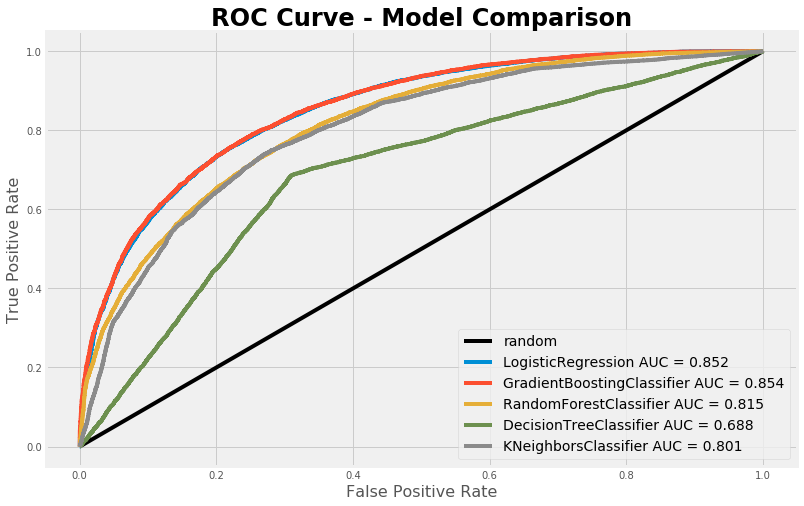

In [420]:
fig, ax = plt.subplots(figsize=(12, 8))

ax.plot([0,1],[0,1], 'k', label="random")
res_list = []

for model in model_list:
    results = modelling(X_train, X_test, y_train, y_test, model)
    res_list.append(results)
    auc_score = results[4]
    plot_roc(ax, results[3], 
             "{} AUC = {}".format(model.__class__.__name__, round(auc_score, 3)))